In [42]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_digits
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize


In [43]:
# Step 1: Load Digits dataset
digits = load_digits()
X = digits.data  # Shape: (1797, 64)
y = digits.target

In [44]:
# Step 2: Mean Centering
X_mean = np.mean(X, axis=0)
X_centered = X - X_mean

In [45]:
# Step 3: QR Decomposition
H = X_centered.T  # (64 x 1797)
Q1, R1 = np.linalg.qr(H, mode='reduced')  # Q1: (64 x t), R1: (t x 1797)

In [46]:
# Step 4: SVD on R1.T
_, D1, Vt = np.linalg.svd(R1.T, full_matrices=False)

In [47]:
# Step 5: Eigenvalues and eigenvectors
Lambda = D1**2
V = Vt.T

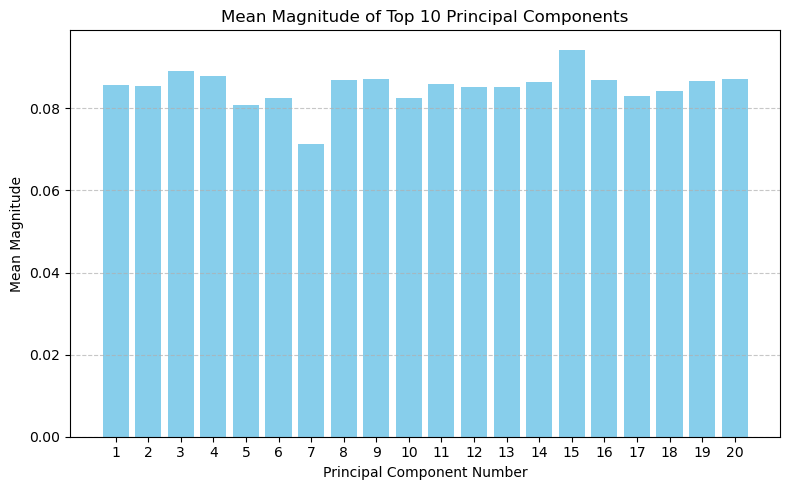

In [48]:
# Step 6: Choose top h principal components
h = 20
Vh = V[:, :h]           
Phi = Q1 @ Vh
# Calculate mean magnitude of each principal component
mean_magnitudes = np.mean(np.abs(Phi), axis=0)
# Plotting bar chart
plt.figure(figsize=(8, 5))
plt.bar(range(1, h+1), mean_magnitudes, color='skyblue')
plt.xlabel('Principal Component Number')
plt.ylabel('Mean Magnitude')
plt.title('Mean Magnitude of Top 10 Principal Components')
plt.xticks(range(1, h+1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

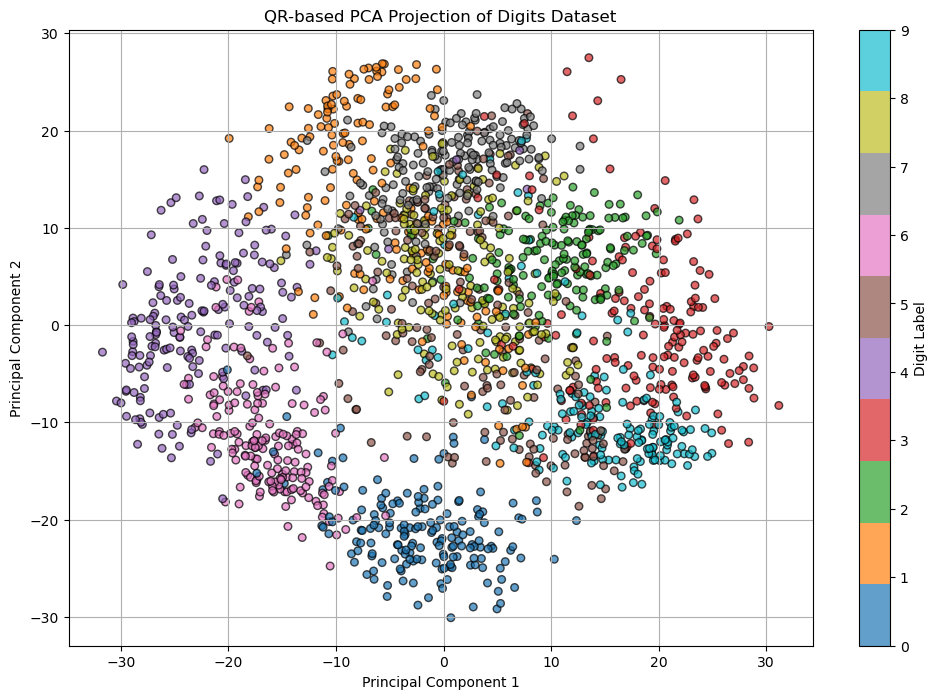

In [49]:
# Step 8: Project data onto lower-dimensional space
Y = X_centered @ Phi  # Shape: (1797 x h)
# Step 9: 2D Visualization of Projected Data
plt.figure(figsize=(12, 8))
scatter = plt.scatter(Y[:, 0], Y[:, 1], c=y, cmap='tab10', s=30, alpha=0.7, edgecolors='k')
plt.colorbar(scatter, ticks=range(10), label='Digit Label')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('QR-based PCA Projection of Digits Dataset')
plt.grid(True)

In [50]:
# Step 13: Reconstruction & Error Calculation
X_reconstructed = Y @ Phi.T + X_mean

# Overall Metrics
rmse = np.sqrt(mean_squared_error(X, X_reconstructed))
mae = mean_absolute_error(X, X_reconstructed)
r2 = r2_score(X, X_reconstructed)

print("\n📉 Reconstruction Metrics:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")

# Optional: Per-digit reconstruction error
print("\n🔍 Per-Digit Reconstruction Error:")
for digit in np.unique(y):
    idx = np.where(y == digit)[0]
    mse_digit = np.mean((X[idx] - X_reconstructed[idx]) ** 2)
    print(f"Digit {digit}: MSE = {mse_digit:.4f}")


📉 Reconstruction Metrics:
RMSE: 1.4086
MAE:  0.9475
R²:   0.6548

🔍 Per-Digit Reconstruction Error:
Digit 0: MSE = 1.6006
Digit 1: MSE = 1.6004
Digit 2: MSE = 2.2420
Digit 3: MSE = 1.7726
Digit 4: MSE = 2.1579
Digit 5: MSE = 2.2716
Digit 6: MSE = 1.6061
Digit 7: MSE = 2.2707
Digit 8: MSE = 2.2372
Digit 9: MSE = 2.0995


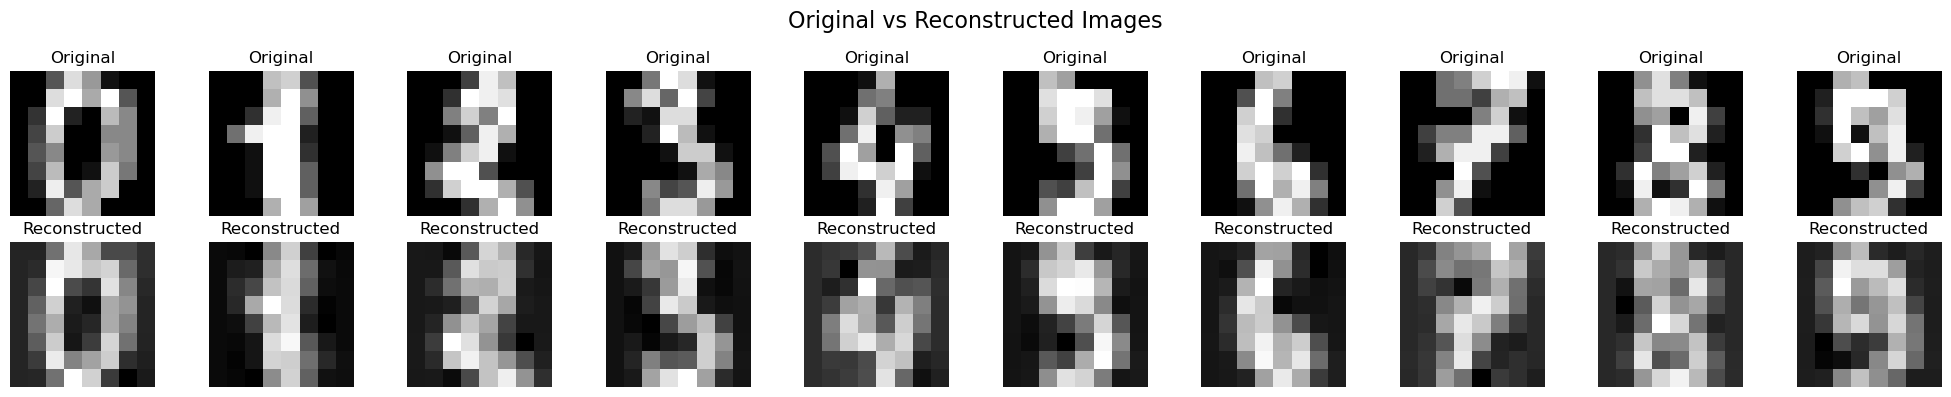

In [51]:
# Step 14: Visualize Original vs Reconstructed Images
n_images = 10
plt.figure(figsize=(20, 4))
for i in range(n_images):
    # Original
    plt.subplot(2, n_images, i + 1)
    plt.imshow(X[i].reshape(8, 8), cmap='gray')
    plt.title("Original")
    plt.axis('off')
    
    # Reconstructed
    plt.subplot(2, n_images, n_images + i + 1)
    plt.imshow(X_reconstructed[i].reshape(8, 8), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.suptitle("Original vs Reconstructed Images", fontsize=16)
plt.tight_layout()
plt.show()

In [52]:
# Step 16: Classification using Logistic Regression
X_train, X_test, y_train, y_test = train_test_split(Y, y, test_size=0.3, random_state=42)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='macro')
rec = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# AUC (multi-class)
y_test_bin = label_binarize(y_test, classes=np.unique(y))
auc = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')

print("\n📊 Classification Metrics:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC Score: {auc:.4f}")


📊 Classification Metrics:
Accuracy:  0.9463
Precision: 0.9468
Recall:    0.9488
F1 Score:  0.9475
AUC Score: 0.9971


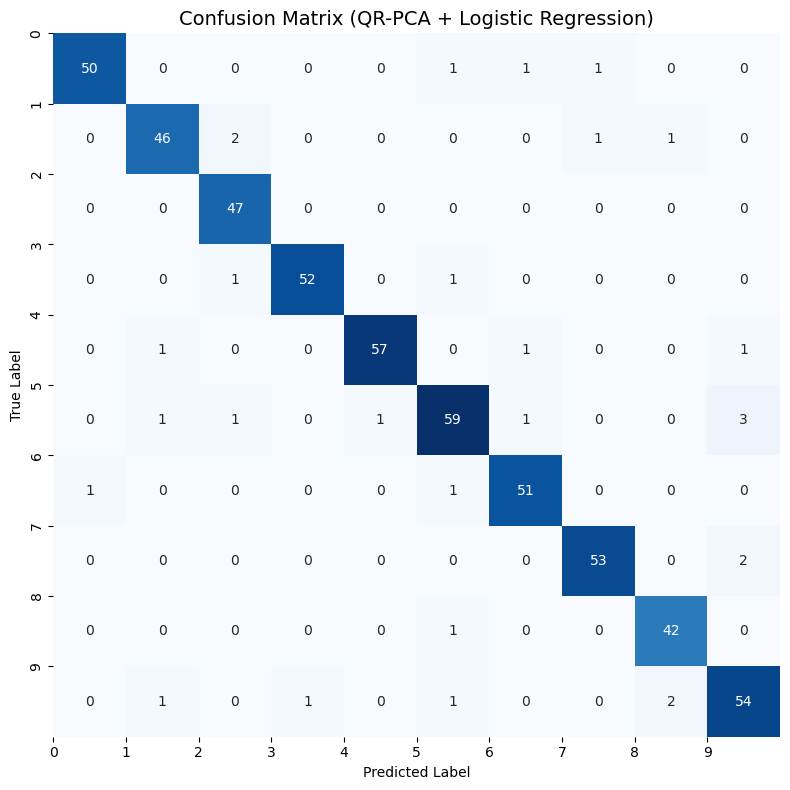

In [53]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix (QR-PCA + Logistic Regression)", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(ticks=np.arange(10), labels=np.arange(10))
plt.yticks(ticks=np.arange(10), labels=np.arange(10))
plt.tight_layout()
plt.show()